In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint



In [40]:
import tensorflow as tf
print(tf.__version__)


2.15.0


#### Read the data

In [41]:
sales_data = pd.read_csv("data_set/train.csv")

sales_data.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


#### check for null values

In [42]:
sales_data.isna().sum()

date     0
store    0
item     0
sales    0
dtype: int64

In [43]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


#### Dropping store and Item coloumns

In [44]:
sales_data = sales_data.drop(['store', 'item'], axis=1)

sales_data.head()

,date,sales
0,2013-01-01,13
1,2013-01-02,11
2,2013-01-03,14
3,2013-01-04,13
4,2013-01-05,10


In [45]:
sales_data['date'].dtype

dtype('O')

#### convert date to date format

In [46]:
sales_data['date'] = pd.to_datetime(sales_data['date'])

sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 13.9 MB


In [47]:
sales_data.head()

,date,sales
0,2013-01-01,13
1,2013-01-02,11
2,2013-01-03,14
3,2013-01-04,13
4,2013-01-05,10


#### converting date to a Month period and then sum the number of items in each month

In [48]:
sales_data['date'] = sales_data['date'].dt.to_period("M")

monthly_sales = sales_data.groupby('date').sum().reset_index()

monthly_sales.head()

,date,sales
0,2013-01,454904
1,2013-02,459417
2,2013-03,617382
3,2013-04,682274
4,2013-05,763242


#### converting the resulting date column to timestamp datatype

In [49]:
monthly_sales['date'] = monthly_sales['date'].dt.to_timestamp()

monthly_sales.head()

,date,sales
0,2013-01-01,454904
1,2013-02-01,459417
2,2013-03-01,617382
3,2013-04-01,682274
4,2013-05-01,763242


#### Visualize the monthly sales

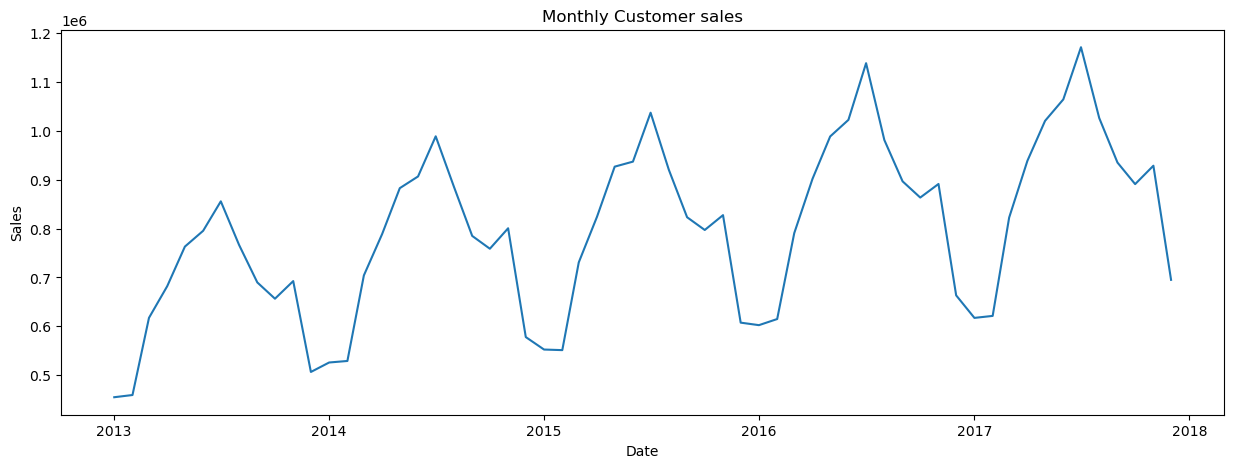

In [50]:
plt.figure(figsize=(15,5))

plt.plot(monthly_sales['date'], monthly_sales['sales'])

plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Monthly Customer sales")
plt.show()

#### call the difference on the sales coloumns to make the sales data stationery

In [51]:
""" The .diff() method calculates the difference between each row and the previous row in the sales column. """

monthly_sales['sales_diff'] = monthly_sales['sales'].diff()

monthly_sales.head(20)



,date,sales,sales_diff
0,2013-01-01,454904,NaN
1,2013-02-01,459417,4513.0
2,2013-03-01,617382,157965.0
3,2013-04-01,682274,64892.0
4,2013-05-01,763242,80968.0
5,2013-06-01,795597,32355.0
6,2013-07-01,855922,60325.0
7,2013-08-01,766761,-89161.0
8,2013-09-01,689907,-76854.0
9,2013-10-01,656587,-33320.0


In [52]:
monthly_sales = monthly_sales.dropna()

monthly_sales.head()

,date,sales,sales_diff
1,2013-02-01,459417,4513.0
2,2013-03-01,617382,157965.0
3,2013-04-01,682274,64892.0
4,2013-05-01,763242,80968.0
5,2013-06-01,795597,32355.0


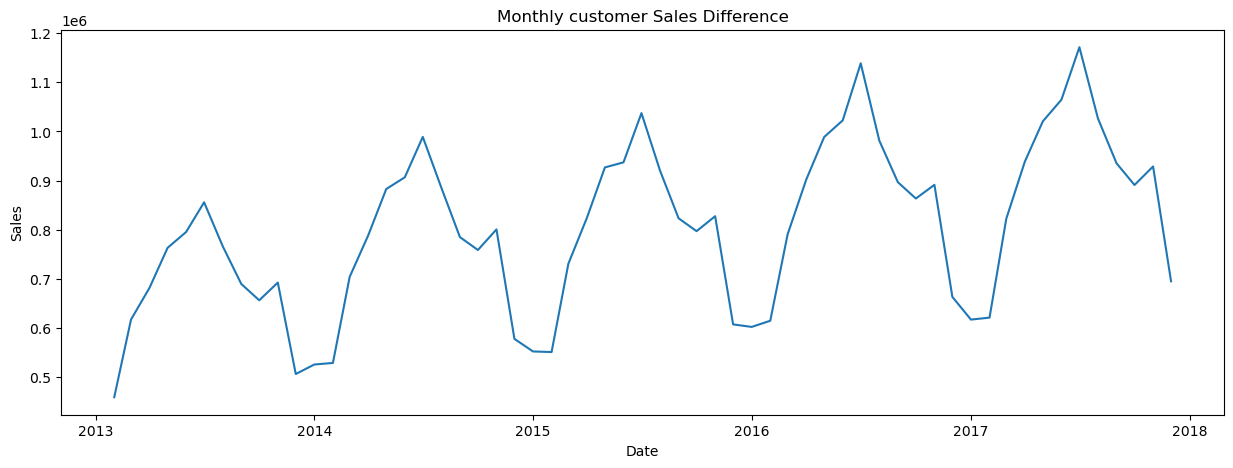

In [53]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'], monthly_sales['sales'])
plt.xlabel("Date")
plt.ylabel("Sales")

plt.title("Monthly customer Sales Difference")
plt.show()


#### create data for supervised learning

In [54]:
supervised_data = monthly_sales.drop(['date','sales'], axis=1)

supervised_data.head()

,sales_diff
1,4513.0
2,157965.0
3,64892.0
4,80968.0
5,32355.0


#### Preparing the supervised data

In [55]:
for i in range(1,13):
    col_name = 'month_' + str(i)
    supervised_data[col_name] = supervised_data['sales_diff'].shift(i)

supervised_data = supervised_data.dropna().reset_index(drop=True)

supervised_data.head(10)

,sales_diff,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0,4513.0
1,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0
2,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0
3,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0
4,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0
5,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0
6,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0
7,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0
8,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0
9,41900.0,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0


#### split data into training and test data

In [56]:
train_data = supervised_data[:-12]
test_data = supervised_data[-12:]

print("Train Data Shape", train_data.shape )
print("Test Data Shape", test_data.shape )

Train Data Shape (35, 13)
Test Data Shape (12, 13)


#### sclaing min max

In [57]:
# Initializing a MinMaxScaler to scale the features to a range between -1 and 1
scaler = MinMaxScaler(feature_range=(-1,1))

# Fitting the scaler on the training data only to prevent data leakage from the test set
scaler.fit(train_data)

# Transforming both the training and testing data with the scaler
# This scales the features in both datasets to the range [-1, 1]
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [ ]:
x_train, y_train = train_data[:,1:], train_data[:,0:1]
x_test, y_test = test_data[:,1:], test_data[:,0:1]